In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime


import pyspark.pandas as ps
from pyspark.sql.functions import col, from_unixtime, date_trunc
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf

In [2]:
try:
    spark.stop()
except NameError:
    pass

In [3]:
# create a Spark session
spark = SparkSession.builder.master("local[4]").appName("Spark Churn").getOrCreate()

23/12/19 23:11:18 WARN Utils: Your hostname, Jacobs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.156 instead (on interface en0)
23/12/19 23:11:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 23:11:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
path = "mini_sparkify_event_data.json"
psdf = spark.read.json(path)
psdf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
pd.DataFrame(data=psdf.dtypes)

0       1
0          artist  string
1            auth  string
2       firstName  string
3          gender  string
4   itemInSession  bigint
5        lastName  string
6          length  double
7           level  string
8        location  string
9          method  string
10           page  string
11   registration  bigint
12      sessionId  bigint
13           song  string
14         status  bigint
15             ts  bigint
16      userAgent  string
17         userId  string

### Check dtypes


In [6]:
# Seperate column types
num_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] != "string"
]
obj_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] == "string"
]

In [7]:
psdf[num_cols].describe().show()

23/12/19 23:11:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+--------------------+-----------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|        sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+-----------------+------------------+--------------------+
|  count|            286500|            228108|              278154|           286500|            286500|              286500|
|   mean|114.41421291448516|249.11718197783583|1.535358834085619...|1041.526554973822|210.05459685863875|1.540956889810394...|
| stddev| 129.7672620114106| 99.23517921058313|3.2913216163281236E9|726.7762634630807|31.505078488421987|  1.50754396082106E9|
|    min|                 0|           0.78322|       1521380675000|                1|               200|       1538352117000|
|    max|              1321|        3024.66567|       1543247354000|             2474|               404|      

In [8]:
psdf.createOrReplaceTempView("user_log_table")
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))
songs_in_hour = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM user_log_table
          WHERE page = "NextSong"
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
)

songs_in_hour_df = songs_in_hour.toPandas()


<Axes: >

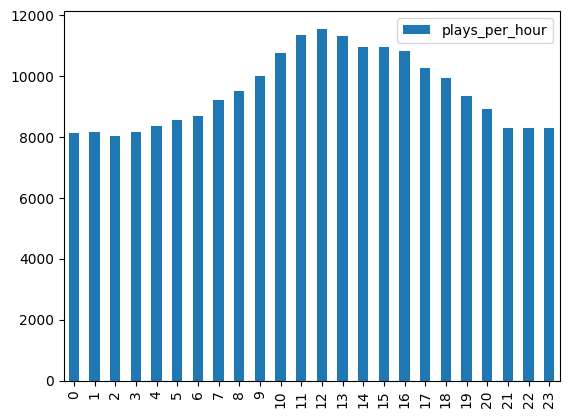

In [9]:
songs_in_hour_df.plot(kind = 'bar')

In [10]:
psdf[obj_cols].describe().show()

+-------+------------------+----------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|lastName| level|         location|method|   page|                song|           userAgent|            userId|
+-------+------------------+----------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|  278154|286500|           278154|286500| 286500|              228108|              278154|            286500|
|   mean| 551.0852017937219|      NULL|     NULL|  NULL|    NULL|  NULL|             NULL|  NULL|   NULL|            Infinity|                NULL| 59682.02278593872|
| stddev|1217.7693079161377|      NULL|     NULL|  NULL|    NULL|  NULL|             NULL|  NULL|   NULL|                 NaN|                NULL|109091.94999910559

## Remove Duplicates and NULLS


### Count Nulls within each feature

In [46]:
def count_nulls(py_df):
    """
    Counts NULL values within a dataframe
    Args:
        py_df (pyspark DataFrame): Input PySpark DataFrame

    Returns:
        pyspark DataFrame: DataFrame with counts of NULL values for each column
    """

    columns = py_df.columns
    null_counts = [F.sum(F.col(column).isNull().cast("int")).alias(column) for column in columns]
    result = py_df.agg(*null_counts)
    return result


In [48]:
count_nulls(psdf).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Two distinct groups of NULLS within the data set. One appears related to user info and the other related to not song info

In [39]:
null_user = spark.sql('''
    select * 
    from user_log_table 
    where userAgent IS NULL;
'''
)

null_user.show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  NULL|Logged Out|     NULL|  NULL|          100|    NULL|  NULL| free|    NULL|   GET| Home|        NULL|        8|NULL|   200|1538355745000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          101|    NULL|  NULL| free|    NULL|   GET| Help|        NULL|        8|NULL|   200|1538355807000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          102|    NULL|  NULL| free|    NULL|   GET| Home|        NULL|        8|NULL|   200|1538355841000|     NULL|      |
|  NULL|Logged Out|     NULL|  NUL

Based on intial observations of NULL userAgent values. User actions appear to be occuring before a user is not logged into the app, thus creating these nulls. We can verify by looking at the unique page visits. 

In [35]:
null_user.groupBy("page").count().orderBy(col("count").desc()).show(psdf.count(), False)


+-------------------+-----+
|page               |count|
+-------------------+-----+
|Home               |4375 |
|Login              |3241 |
|About              |429  |
|Help               |272  |
|Register           |18   |
|Error              |6    |
|Submit Registration|5    |
+-------------------+-----+



In [53]:
count_nulls(psdf.na.drop(subset = ['userAgent'])).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [54]:
psdf.na.drop(subset = ['userAgent']).groupBy("page").count().orderBy(col("count").desc()).show(psdf.count(), False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Home                     |10082 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Settings                 |1514  |
|Help                     |1454  |
|Upgrade                  |499   |
|About                    |495   |
|Save Settings            |310   |
|Error                    |252   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
+-------------------------+------+



In [27]:
# print(psdf.count())
# clean_psdf = psdf.dropDuplicates()
# clean_psdf.count()
# clean_psdf = clean_psdf.na.drop()

# clean_psdf.count()

## Feature Counts

In [29]:
dcounts = []
for i in obj_cols:
    dcounts.append(psdf[[i]].distinct().count())

pd.DataFrame(data=dcounts, index=obj_cols, columns=["Unique Counts"])

Unique Counts
artist             17656
auth                   4
firstName            190
gender                 3
lastName             174
level                  2
location             115
method                 2
page                  22
song               58481
userAgent             57
userId               226

Since we are trying to predict whether or not a individual will cancel or "downgrade" , we will need to explore the "page" feature

In [30]:
psdf.groupBy("page").count().orderBy(col("count").desc()).show(psdf.count(), False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



### Unique Counts of Upgrades/Downgrades


In [31]:
psdf[["page"]].filter(col("page").like("%grade%")).groupBy("page").count().sort(
    "count", ascending=False
).show()

+----------------+-----+
|            page|count|
+----------------+-----+
|       Downgrade| 2055|
|         Upgrade|  499|
|  Submit Upgrade|  159|
|Submit Downgrade|   63|
+----------------+-----+



In [32]:
psdf[['artist']].groupBy('artist').count().orderBy(col("count").desc()).show(psdf.count(), False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|artist                                                                                                                                                                                                                                                                                                                        |count|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|NULL              

# Feature Extraction